In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', None)

In [3]:
df4 = pd.read_csv("C:\\Users\\chloe\\Desktop\\Datascientest\\Projet pompiers\\LFB Incident data from 2009 - 2017.csv", low_memory=False)
df5 = pd.read_excel("C:\\Users\\chloe\\Desktop\\Datascientest\\Projet pompiers\\LFB Incident data from 2018.xlsx")
df1 = pd.read_excel("C:\\Users\\chloe\\Desktop\\Datascientest\\Projet pompiers\\LFB Mobilisation data from January 2009 - 2014.xlsx")
df2 = pd.read_excel("C:\\Users\\chloe\\Desktop\\Datascientest\\Projet pompiers\\LFB Mobilisation data from 2015 - 2020.xlsx")
df3 = pd.read_excel("C:\\Users\\chloe\\Desktop\\Datascientest\\Projet pompiers\\LFB Mobilisation data 2021 - 2024.xlsx")

In [5]:
# Remplacement des valeurs de la colonne TravelTimeSeconds dans df3 par un calcul, car une majorité des données étaient dans un mauvais format
df3['TravelTimeSeconds'] = df3['AttendanceTimeSeconds'] - df3['TurnoutTimeSeconds']

In [7]:
mobilisation = pd.concat([df1, df2, df3], axis = 0)

C:\Users\chloe\AppData\Local\Temp\ipykernel_16932\2163882519.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mobilisation = pd.concat([df1, df2, df3], axis = 0)


In [9]:
# Sélection des colonnes pour le df mobilisation
nouvel_ordre = ["IncidentNumber", "CalYear", "HourOfCall", "DateAndTimeMobile", "DateAndTimeArrived", "AttendanceTimeSeconds", "TurnoutTimeSeconds", "TravelTimeSeconds", "DateAndTimeLeft", "DeployedFromStation_Name", "DelayCode_Description"]

mobilisation = mobilisation[nouvel_ordre]

In [11]:
# Suppression des NA pour les colonnes où ils représentent moins de 2 %
mobilisation = mobilisation.dropna(axis = 0, subset=['TravelTimeSeconds', 'TurnoutTimeSeconds', 'DateAndTimeLeft', 'DeployedFromStation_Name'])

In [13]:
# Remplacement des NA restant, tous dans la colonne DelayCode_Description, par une valeur
mobilisation = mobilisation.replace(to_replace=np.nan, value="Not specified")

In [15]:
# Uniformisation des types 
dictionnaire = {
    'IncidentNumber': 'object',
    'DeployedFromStation_Name': 'object',
    'DelayCode_Description': 'object',
    'DateAndTimeMobile': 'datetime64[ns]',
    'DateAndTimeArrived': 'datetime64[ns]',
    'DateAndTimeLeft': 'datetime64[ns]',
    'CalYear': 'int',
    'HourOfCall': 'int',
    'AttendanceTimeSeconds': 'int',
    'TurnoutTimeSeconds': 'int',
    'TravelTimeSeconds': 'int'
}

mobilisation = mobilisation.astype(dictionnaire)

In [17]:
incidents = pd.concat([df4, df5], axis = 0)

In [19]:
# Sélection des colonnes pour le df incidents
ordre_incidents = ["IncidentNumber", "TimeOfCall", "IncidentStationGround", "NumStationsWithPumpsAttending", "PumpCount", "IncidentGroup", "StopCodeDescription", "ProperCase", "Notional Cost (£)", "Latitude", "Longitude", "AddressQualifier"]

incidents = incidents[ordre_incidents]

In [21]:
# Suppression des NA pour les colonnes où ils représentent moins de 2 %
incidents = incidents.dropna(axis = 0, subset=['IncidentGroup', 'NumStationsWithPumpsAttending', 'AddressQualifier', 'IncidentStationGround'])

In [23]:
# Conversion des colonnes latitude et longitude en float
incidents['Latitude'] = incidents['Latitude'].str.replace(',', '.').astype(float)
incidents['Longitude'] = incidents['Longitude'].str.replace(',', '.').astype(float)

AttributeError: Can only use .str accessor with string values!

In [26]:
# Remplacement des NA dans ces colonnes par la valeur moyenne calculée par quartier
incidents['Latitude'] = incidents.groupby('ProperCase')['Latitude'].transform(lambda x: x.fillna(x.mean()))
incidents['Longitude'] = incidents.groupby('ProperCase')['Longitude'].transform(lambda x: x.fillna(x.mean()))

In [28]:
# Uniformisation des types 
dictionnaire = {
    'IncidentNumber': 'object',
    "TimeOfCall": 'object', 
    "IncidentStationGround": 'object', 
    "NumStationsWithPumpsAttending": 'int', 
    "PumpCount": 'int', 
    "IncidentGroup": 'object', 
    "StopCodeDescription": 'object', 
    "ProperCase": 'object', 
    "Notional Cost (£)": 'float', 
    "AddressQualifier": 'object'
}

incidents = incidents.astype(dictionnaire)

In [30]:
# Suppression des vrais doublons dans mobilisation
mobilisation = mobilisation.drop_duplicates(subset=None, keep='first')

In [32]:
lfb = mobilisation.merge(right=incidents, on='IncidentNumber', how='inner')

In [33]:
# Récupération des informations sur le jour et le mois de l'incident et création des colonnes 
lfb['DateAndTimeMobile'] = pd.to_datetime(lfb['DateAndTimeMobile'])
lfb['CalDay'] = lfb['DateAndTimeMobile'].dt.day
lfb['CalMonth'] = lfb['DateAndTimeMobile'].dt.month

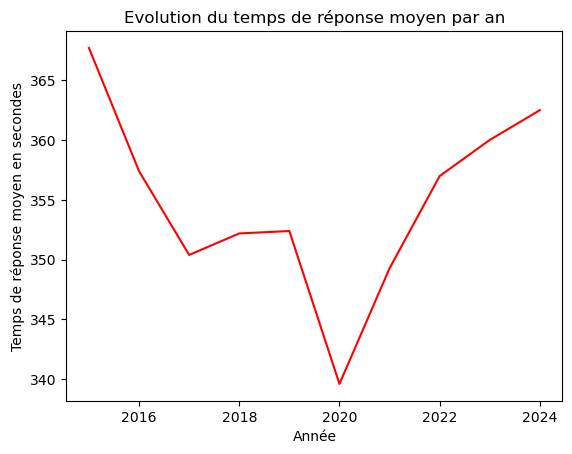

In [35]:
# Créations des graphiques
mean_attendance_per_year = lfb.groupby('CalYear')['AttendanceTimeSeconds'].mean()

plt.plot(mean_attendance_per_year.index, mean_attendance_per_year.values, color="red")
plt.xlabel('Année')
plt.ylabel('Temps de réponse moyen en secondes')
plt.title("Evolution du temps de réponse moyen par an")
plt.show()

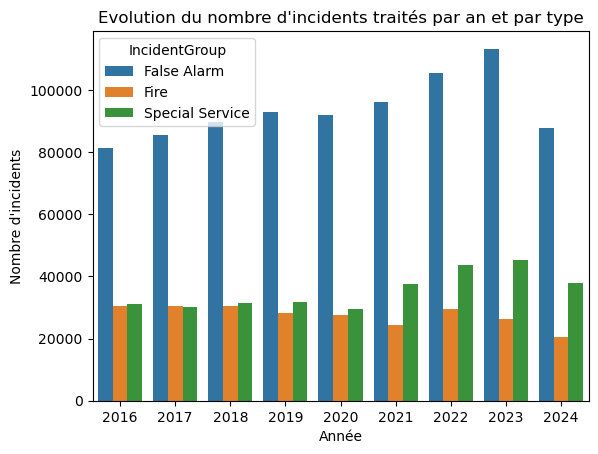

In [37]:
lfb_filtered = lfb[lfb['CalYear'] > 2015]

incident_counts_per_group = lfb_filtered.groupby(['CalYear', 'IncidentGroup'])['IncidentNumber'].count().reset_index()

incident_counts_per_group.rename(columns={'IncidentNumber': 'IncidentCount'}, inplace=True)

sns.barplot(data=incident_counts_per_group, x='CalYear', y='IncidentCount', hue='IncidentGroup')
plt.xlabel('Année')
plt.ylabel('Nombre d\'incidents')
plt.title('Evolution du nombre d\'incidents traités par an et par type')
plt.show()

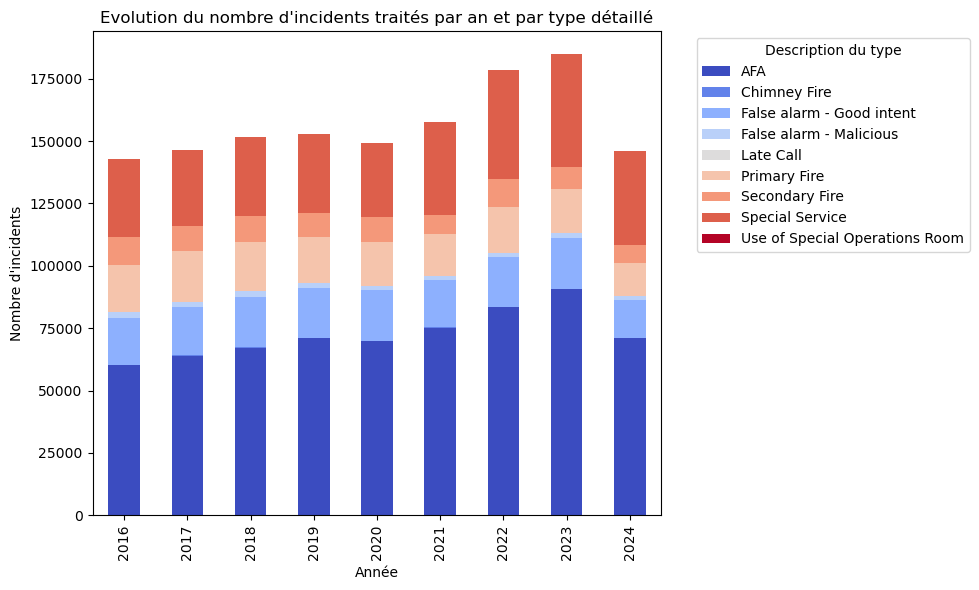

In [39]:
lfb_filtered = lfb[lfb['CalYear'] > 2015]

incident_counts_per_scd = lfb_filtered.groupby(['CalYear', 'StopCodeDescription'])['IncidentNumber'].count().reset_index()

incident_counts_per_scd.rename(columns={'IncidentNumber': 'IncidentCount'}, inplace=True)

incident_pivot = incident_counts_per_scd.pivot_table(index='CalYear', columns='StopCodeDescription', values='IncidentCount', aggfunc='sum', fill_value=0)

incident_pivot.plot(kind='bar', stacked=True, figsize=(10, 6),  colormap='coolwarm')

plt.xlabel('Année')
plt.ylabel('Nombre d\'incidents')
plt.title('Evolution du nombre d\'incidents traités par an et par type détaillé')
plt.legend(title='Description du type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  
plt.show()


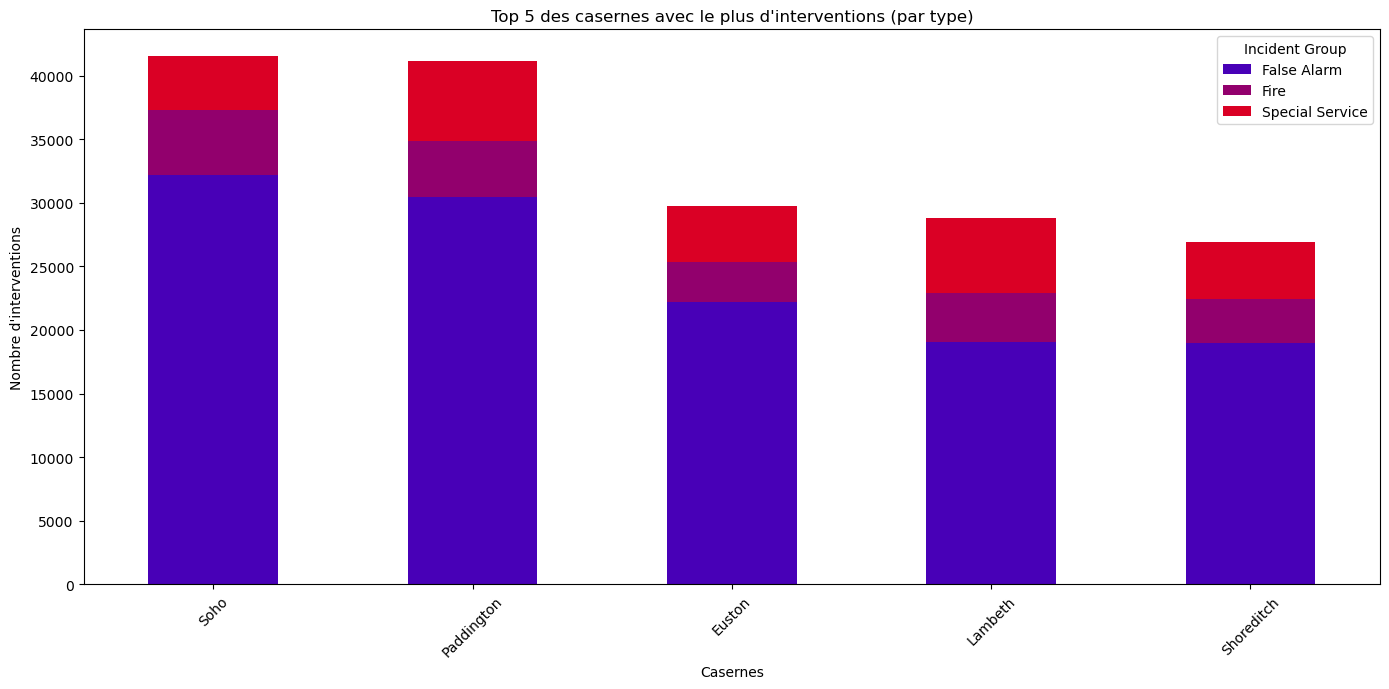

In [41]:
nb_intervention_station = lfb_filtered.groupby("IncidentStationGround").size()

grouped_data = lfb_filtered.groupby(['IncidentStationGround', 'IncidentGroup']).size().unstack(fill_value=0)

top_5_stations = nb_intervention_station.sort_values(ascending=False).head(5).index

grouped_data_top_5 = grouped_data.loc[top_5_stations]

sns.set_palette("brg")
grouped_data_top_5.plot(kind='bar', stacked=True, figsize=(14, 7))

plt.xlabel('Casernes')
plt.ylabel('Nombre d\'interventions')
plt.title('Top 5 des casernes avec le plus d\'interventions (par type)')
plt.xticks(rotation=45)
plt.legend(title='Incident Group')
plt.tight_layout()  # Ajuste les éléments pour éviter les chevauchements
plt.show()

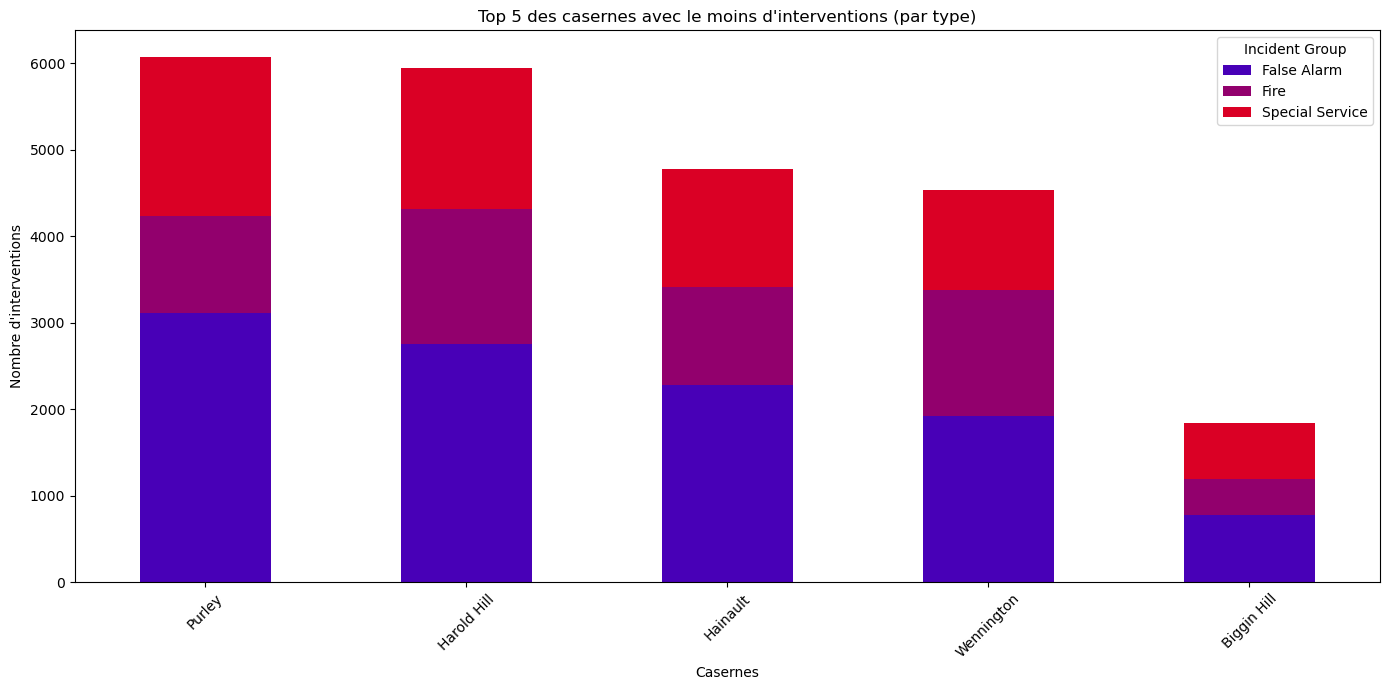

In [43]:
bottom_5_stations = nb_intervention_station.sort_values(ascending=False).tail(5).index

grouped_data_bottom_5 = grouped_data.loc[bottom_5_stations]

sns.set_palette("brg")
grouped_data_bottom_5.plot(kind='bar', stacked=True, figsize=(14, 7))

plt.xlabel('Casernes')
plt.ylabel('Nombre d\'interventions')
plt.title('Top 5 des casernes avec le moins d\'interventions (par type)')
plt.xticks(rotation=45)
plt.legend(title='Incident Group')
plt.tight_layout()
plt.show()

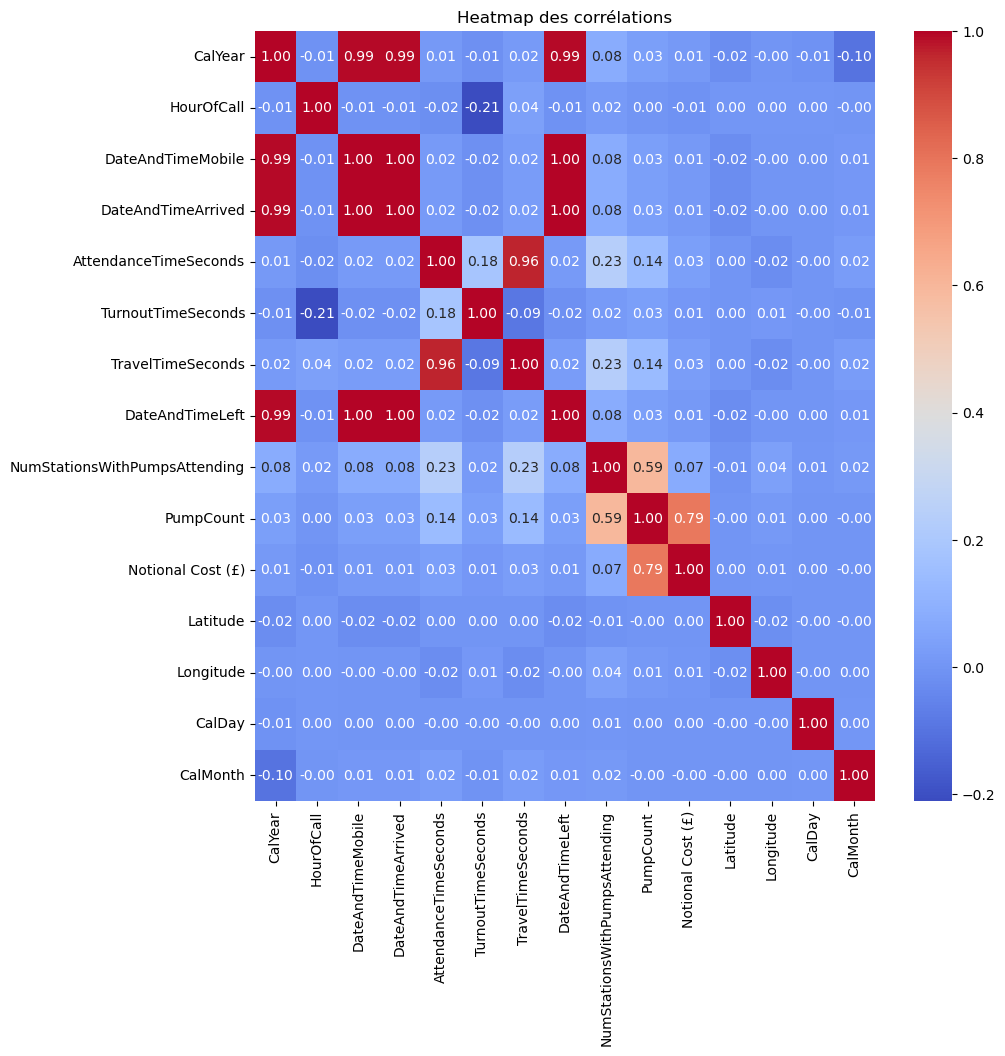

In [45]:
col_num = lfb.select_dtypes(include=['int', 'float', 'datetime'])

corr_matrix = col_num.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Heatmap des corrélations")
plt.show()

In [7]:
lfb = pd.read_csv("C:\\Users\\chloe\\Desktop\\Datascientest\\Projet pompiers\\lfb.csv", low_memory=False)

In [34]:
lfb.to_csv("C:\\Users\\chloe\\Desktop\\Datascientest\\Projet pompiers\\lfb.csv", index=False)

In [143]:
lfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425721 entries, 0 to 1425720
Data columns (total 22 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   IncidentNumber                 1425721 non-null  object 
 1   CalYear                        1425721 non-null  int64  
 2   HourOfCall                     1425721 non-null  int64  
 3   DateAndTimeMobile              1425721 non-null  object 
 4   DateAndTimeArrived             1425721 non-null  object 
 5   AttendanceTimeSeconds          1425721 non-null  int64  
 6   TurnoutTimeSeconds             1425721 non-null  int64  
 7   TravelTimeSeconds              1425721 non-null  int64  
 8   DateAndTimeLeft                1425721 non-null  object 
 9   DeployedFromStation_Name       1425721 non-null  object 
 10  DelayCode_Description          1425721 non-null  object 
 11  TimeOfCall                     1425721 non-null  object 
 12  IncidentStatio

In [ ]:
On veut prévoir AttendanceTimeSeconds

On a besoin de :
TurnoutTimeSeconds
TravelTimeSeconds   # finalement je rééssaie le ML en supprimant cette colonne car trop correlée à la cible donc surapprentissage
HourOfCall
Latitude 
Latitude
CalYear

et de :
encodage avec ohe : variables non ordinales
DeployedFromStation_Name
IncidentStationGround
StopCodeDescription
ProperCase
IncidentGroup

In [161]:
# Vérification des colonnes avant suppression
columns_to_drop = ['IncidentNumber', 'DateAndTimeMobile', 'DateAndTimeArrived', 'TravelTimeSeconds',
                   'DateAndTimeLeft','DelayCode_Description','TimeOfCall','NumStationsWithPumpsAttending',
                   'PumpCount','Notional Cost (£)','AddressQualifier']

# Supprimer les colonnes existantes
lfb = lfb.drop([col for col in columns_to_drop if col in lfb.columns], axis=1)

In [163]:
lfb.head()

,CalYear,HourOfCall,AttendanceTimeSeconds,TurnoutTimeSeconds,DeployedFromStation_Name,IncidentStationGround,IncidentGroup,StopCodeDescription,ProperCase,Latitude,Longitude
0,2015,2,319,119,Woodside,Croydon,False Alarm,AFA,Croydon,51.321834,-0.091456
1,2015,2,335,123,Soho,Soho,False Alarm,AFA,Westminster,51.517917,-0.145588
2,2015,2,418,120,Whitechapel,Whitechapel,Special Service,Special Service,City Of london,51.458547,-0.091026
3,2015,2,261,190,Stratford,Stratford,False Alarm,AFA,Newham,51.551287,0.024765
4,2015,2,404,55,Soho,Soho,False Alarm,AFA,Westminster,51.509485,-0.151478


In [165]:
colonnes_a_encoder = ['DeployedFromStation_Name', 'IncidentStationGround', 'StopCodeDescription', 'ProperCase', 'IncidentGroup']

# Appliquer One-Hot Encoding sur les colonnes sélectionnées
lfb_encoded = pd.get_dummies(lfb, columns=colonnes_a_encoder, drop_first=True)

# Afficher les 5 premières lignes pour vérifier le résultat
print(lfb_encoded.head())

   CalYear  HourOfCall  AttendanceTimeSeconds  TurnoutTimeSeconds   Latitude  \
0     2015           2                    319                 119  51.321834   
1     2015           2                    335                 123  51.517917   
2     2015           2                    418                 120  51.458547   
3     2015           2                    261                 190  51.551287   
4     2015           2                    404                  55  51.509485   

   Longitude  DeployedFromStation_Name_Addington  \
0  -0.091456                               False   
1  -0.145588                               False   
2  -0.091026                               False   
3   0.024765                               False   
4  -0.151478                               False   

   DeployedFromStation_Name_Barking  DeployedFromStation_Name_Barnet  \
0                             False                            False   
1                             False                           

In [167]:
lfb_encoded.head()

,CalYear,HourOfCall,AttendanceTimeSeconds,TurnoutTimeSeconds,Latitude,Longitude,DeployedFromStation_Name_Addington,DeployedFromStation_Name_Barking,DeployedFromStation_Name_Barnet,DeployedFromStation_Name_Battersea,...,ProperCase_Redbridge,ProperCase_Richmond Upon thames,ProperCase_Southwark,ProperCase_Sutton,ProperCase_Tower Hamlets,ProperCase_Waltham Forest,ProperCase_Wandsworth,ProperCase_Westminster,IncidentGroup_Fire,IncidentGroup_Special Service
0,2015,2,319,119,51.321834,-0.091456,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2015,2,335,123,51.517917,-0.145588,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2015,2,418,120,51.458547,-0.091026,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2015,2,261,190,51.551287,0.024765,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2015,2,404,55,51.509485,-0.151478,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [169]:
# vérifier combien de colonnes ont été ajoutées après l'encodage :

print(f"Nombre de colonnes initial : {lfb.shape[1]}")
print(f"Nombre de colonnes après encodage : {lfb_encoded.shape[1]}")

Nombre de colonnes initial : 11
Nombre de colonnes après encodage : 249


In [171]:
# standardiser les colonnes numériques


from sklearn.preprocessing import StandardScaler

# Sélectionner les colonnes numériques à standardiser
colonnes_numeriques = ['TurnoutTimeSeconds', 'HourOfCall', 'Latitude', 'Longitude', 'CalYear']

# Initialiser le scaler
scaler = StandardScaler()

# Appliquer la standardisation
lfb_encoded[colonnes_numeriques] = scaler.fit_transform(lfb_encoded[colonnes_numeriques])

# Afficher les 5 premières lignes pour vérifier
print(lfb_encoded.head())


    CalYear  HourOfCall  AttendanceTimeSeconds  TurnoutTimeSeconds  Latitude  \
0 -1.953755   -1.792668                    319            1.095577 -0.067372   
1 -1.953755   -1.792668                    335            1.194195  0.058003   
2 -1.953755   -1.792668                    418            1.120231  0.020042   
3 -1.953755   -1.792668                    261            2.846060  0.079340   
4 -1.953755   -1.792668                    404           -0.482323  0.052612   

   Longitude  DeployedFromStation_Name_Addington  \
0   0.200163                               False   
1  -0.194377                               False   
2   0.203298                               False   
3   1.047256                               False   
4  -0.237313                               False   

   DeployedFromStation_Name_Barking  DeployedFromStation_Name_Barnet  \
0                             False                            False   
1                             False                           

In [173]:
# Afficher les colonnes de type object
colonnes_object = lfb_encoded.select_dtypes(include=['object']).columns
print("Colonnes de type 'object' :")
print(colonnes_object)


Colonnes de type 'object' :
Index([], dtype='object')


In [183]:
lfb_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425721 entries, 0 to 1425720
Columns: 249 entries, CalYear to IncidentGroup_Special Service
dtypes: bool(243), float64(5), int64(1)
memory usage: 395.7 MB


In [185]:
# création de l'entrainement et du test

from sklearn.model_selection import train_test_split

# Définir les features (X) et la target (y)
X = lfb_encoded.drop('AttendanceTimeSeconds', axis=1)
y = lfb_encoded['AttendanceTimeSeconds']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensions de l'ensemble d'entraînement : {X_train.shape}")
print(f"Dimensions de l'ensemble de test : {X_test.shape}")


Dimensions de l'ensemble d'entraînement : (1140576, 248)
Dimensions de l'ensemble de test : (285145, 248)


In [187]:
# création d'un modèle de régression linéaire

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialiser et entraîner le modèle
modele = LinearRegression()
modele.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = modele.predict(X_test)

# Évaluer le modèle
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Mean Squared Error (MSE) : {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient de détermination (R²) : {r2_score(y_test, y_pred):.2f}")


Mean Absolute Error (MAE) : 104.36
Mean Squared Error (MSE) : 20087.21
Coefficient de détermination (R²) : 0.10


In [ ]:
# MAE : en moyenne, le modèle se trompe de 104.36 unités par rapport aux valeurs réelles. 
# Plus cette valeur est faible, mieux c'est

# MSE : mesure qui donne plus de poids aux erreurs importantes (grandes différences entre les valeurs prédites et réelles)
# plus cette valeur est basse, plus le modèle est précis
# MSE élevé = modèle a des erreurs assez importantes

# R² : il n'explique que 10% de la variance des données, ce qui signifie qu'il n'est pas très performant. Sans doute qu'avec ce taux,
# ça veut dire qu'il y a des aspects importants dans les données que le modèle n'arrive pas à capter
# R² proche de 1 serait idéal

In [191]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Séparer les features et la target
X = lfb_encoded.drop('AttendanceTimeSeconds', axis=1)  # Remplace 'TargetColumn' par le nom de ta variable cible
y = lfb_encoded['AttendanceTimeSeconds']

# 2. Séparer les données en train et test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Créer le modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 4. Entraîner le modèle
rf_model.fit(X_train, y_train)

# 5. Faire des prédictions
y_pred = rf_model.predict(X_test)

# 6. Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R²:", r2)


MemoryError: could not allocate 134217728 bytes

In [193]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Supposons que 'lfb' est ton DataFrame

# 1. Sous-échantillonnage du jeu de données à 10-20% (par exemple, 20%)
lfb_sampled = lfb_encoded.sample(frac=0.2, random_state=42)

# 2. Convertir les données en float32 pour économiser de la mémoire
X = lfb_sampled.drop('AttendanceTimeSeconds', axis=1).astype('float32')  # Remplace 'AttendanceTimeSeconds' par la cible
y = lfb_sampled['AttendanceTimeSeconds'].astype('float32')

# 3. Séparer les données en train et test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Créer le modèle Random Forest avec une limitation sur la profondeur des arbres et le nombre d'arbres
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)  # Réduction du nombre d'arbres et profondeur

# 5. Entraîner le modèle
rf_model.fit(X_train, y_train)

# 6. Faire des prédictions
y_pred = rf_model.predict(X_test)

# 7. Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R²:", r2)


Mean Absolute Error (MAE): 102.37889820259115
Mean Squared Error (MSE): 19440.718354710778
R²: 0.12088669240064709


In [ ]:
Étape 8 : Conclusion
Interpréter les résultats :
Quel modèle fonctionne le mieux ?
Quelles features semblent les plus importantes pour la prédiction ?
Présenter tes conclusions métiers :
Quelles casernes de pompiers ont les temps de réponse les plus rapides ?
Quels facteurs influencent le plus le temps de réponse ?